In [1]:
import pickle
import glob
import os
from tqdm import tqdm
import numpy as np
import copy
num_classes = 19
exp = 'distribution'

def read_exp_dir(ds, exp='table'):
    exp_dir = f'/BS/mlcysec2/work/hierarchical-certification/log/{ds}/{exp}'
    overall_dict = {}
    for file in tqdm(glob.glob(os.path.join(exp_dir, '*.pkl'))[:100], desc=f'reading from {exp_dir}'):
        d = pickle.load(open(file, 'rb'))
        filename = os.path.basename(file).replace('.pkl', '')
        new_d = {}
        new_d[filename] = d[filename]
        d = new_d
        for image_name, image_d in d.items():
            for model_type, model_d in image_d.items():
                if model_type not in overall_dict:
                    overall_dict[model_type] = {}
                for metric, value in model_d.items():
                    if isinstance(value, dict):
                        for k, v in value.items():
                            if isinstance(v, dict):
                                if metric not in overall_dict[model_type]:
                                    overall_dict[model_type][metric] = {}
                                if k not in overall_dict[model_type][metric]:
                                    overall_dict[model_type][metric][k] = {}
                                for k_, v_ in v.items():
                                    if k_ not in overall_dict[model_type][metric][k]:
                                        overall_dict[model_type][metric][k][k_] = v_
                                    else:
                                        overall_dict[model_type][metric][k][k_] += v_
                            else:
                                if k not in overall_dict[model_type]:
                                    overall_dict[model_type][k] = v
                                else:
                                    overall_dict[model_type][k] += v
                                
                        continue
                    if metric not in overall_dict[model_type]:
                        overall_dict[model_type][metric] = value
                    else:
                        overall_dict[model_type][metric] += value
    return overall_dict

dir_dict = {}
for ds in ['cityscapes', 'acdc', 'cocostuff', 'pascal_ctx']:
    dir_dict[ds] = read_exp_dir(ds, exp)

reading from /BS/mlcysec2/work/hierarchical-certification/log/cityscapes/distribution: 100%|██████████| 100/100 [00:00<00:00, 470.20it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/acdc/distribution: 100%|██████████| 100/100 [00:00<00:00, 878.52it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/cocostuff/distribution: 100%|██████████| 100/100 [00:00<00:00, 391.67it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/pascal_ctx/distribution: 100%|██████████| 100/100 [00:00<00:00, 899.09it/s]


In [2]:
def round_numbers(numbers, target_sum=100.0):
    # Step 1: Scale the numbers and the target sum by 10
    scaled_numbers = [num * 10 for num in numbers]
    scaled_target_sum = int(target_sum * 10)

    # Step 2: Basic rounding and calculate the preliminary sum
    rounded = [round(num) for num in scaled_numbers]
    rounded_sum = __builtins__.sum(rounded)
    
    # Step 3: Calculate the difference needed to reach the scaled target sum
    diff = scaled_target_sum - rounded_sum

    # Step 4: Calculate fractional parts and adjust if needed
    if diff != 0:
        remainders = [(num - int(num), index) for index, num in enumerate(scaled_numbers)]
        remainders.sort(reverse=True, key=lambda x: x[0])  # Sort by fractional remainder, largest first
        adjustment_indices = [index for _, index in remainders[:abs(diff)]]  # Adjust based on the largest remainders
        
        for i in adjustment_indices:
            if diff > 0:
                rounded[i] += 1
            else:
                rounded[i] -= 1

    # Step 5: Scale back the rounded numbers
    final_rounded = [round(num / 10, 1) for num in rounded]

    return final_rounded

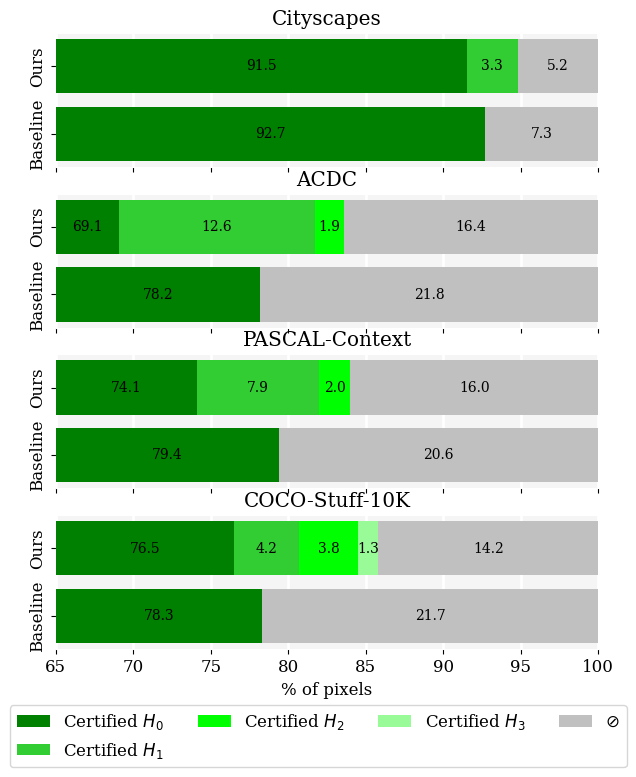

In [3]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as ticker

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fig, axes = plt.subplots(4, 1, figsize=(7,8), sharex=True)
fig.subplots_adjust(hspace=0.2)  # Adjust the value (0.5 in this case) based on your preference
gdata = {}
for ds, ds_dict in dir_dict.items():
    gdata[ds] = {'Ours': [], 'Baseline': []}
    for model_type, model_dict in ds_dict.items():
        if isinstance(model_type, tuple):
            n, n0, f, hi, sigma, tau = model_type
            if f != None:
                for k, v in model_dict.items():
                    if k != 'h_distribution_dict': continue
                    abstain = 0
                    for level in range(4):
                        if level not in v: 
                            gdata[ds]['Ours'].append(0)
                            continue
                        level_d = v[level]
                        certified_per_level = level_d['certified_per_level']/model_dict['num_pixels']*100
                        abstain += level_d['abstain_per_level']/model_dict['num_pixels']*100
                        if f != None: # adaptivecertify
                            gdata[ds]['Ours'].append(certified_per_level)
            else:
                gdata[ds]['Baseline'] = [0]*4
                gdata[ds]['Baseline'][0] = model_dict['certified_count']/model_dict['num_pixels']*100

                        
            if f != None: # adaptivecertify
                gdata[ds]['Ours'].append(abstain)
                gdata[ds]['Ours'] = round_numbers(gdata[ds]['Ours'])
            else:
                gdata[ds]['Baseline'].append(model_dict['abstain_count']/model_dict['num_pixels']*100)
                gdata[ds]['Baseline'] = round_numbers(gdata[ds]['Baseline'])


colors = ['green', 'limegreen', 'lime', 'palegreen', 'silver']
colx = 0
ds_map = {'cityscapes': 'Cityscapes', 'acdc': 'ACDC', 'pascal_ctx': 'PASCAL-Context', 'cocostuff':'COCO-Stuff-10K'}

for colx, ds in enumerate(['cityscapes', 'acdc', 'pascal_ctx', 'cocostuff']):
    gdata_ds = gdata[ds]
    labels = list(gdata_ds.keys()) 
    data = np.array(list(gdata_ds.values()))
    data_cum = data.cumsum(axis=1)
    axes[colx].invert_yaxis()
    minx = 65
    axes[colx].set_xlim(minx, 100)
    category_names = [f'Certified $H_{i}$' for i in range(4)] + ['$\oslash$']

    for i, (colname, color) in enumerate(zip(category_names, colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        axes[colx].barh(labels, widths, left=starts, label=colname, color=color,  zorder=3, height=0.8)
        if i ==0:
            xcenters = widths/2 + minx/2
        else:
            xcenters = starts + widths / 2
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                axes[colx].text(x, y, str(c), ha='center', va='center', fontsize=10, color='black')
    axes[colx].grid(color = 'white', linestyle = '-', linewidth = 2, alpha=1, zorder=0)
    plt.setp(axes[colx].spines.values(), color='white')
    axes[colx].set_facecolor('whitesmoke')
    axes[colx].set_title(ds_map[ds])
    for label in axes[colx].get_yticklabels():
        label.set_rotation(90)
        label.set_va('center')   

axes[3].set_xlabel(r'% of pixels')
# fig.text(0.5, 0.90, 'PASCAL-Context', fontsize=16, ha='center')
# fig.text(0.5, 0.47, 'COCO-Stuff-10K', fontsize=16, ha='center')
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05))
plt.savefig('/BS/mlcysec2/work/hierarchical-certification/graph_images/dist_bar_all.pdf', bbox_inches="tight")
       

In [ ]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as ticker

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fig, axes = plt.subplots(2, 1, figsize=(7,4), sharex=True)
col_i = 0
# Function x**(1/2)
def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2
colors = ['green', 'limegreen', 'lime', 'silver']
width = 0.6
for colx, ds in enumerate(['cocostuff', 'pascal_ctx']):
    n=100
    n0 = 10
    x_axis = []
    y_axis = [0, 0]
    y1, y2 = 0, 0
    category_names = [f'Certified $H_{i}$' for i in range(3)] + ['$\oslash$']
    gdata = {'    Ours  ':[], 'Baseline          ': []}
    y_abstain1, y_abstain2 = 0, 0
    for i in range(3):
        if ds == 'cityscapes': # ada
            k = (n, n0, str((0, 0, 0.25)), 4)
        else:
            k = (n, n0, str((0, 0.05, 0.3)), 4)
        gdata['    Ours  '].append(round(level_d['certified_per_level']/model_dict['num_pixels']*100, 1))
        y_abstain1 +=round(level_d['abstain_per_level']/model_dict['num_pixels']*100, 1)
        k = (n, n0, None, 0)
        gdata['Baseline          '].append(round(graph_dict[k]['h_distribution_dict'][i]['li_certify_count']/graph_dict[k]['num_pixels']*100, 1))
        y_abstain2 +=round(graph_dict[k]['h_distribution_dict'][i]['li_abstain_count']/graph_dict[k]['num_pixels']*100, 1)
    gdata['    Ours  '].append(y_abstain1)
    gdata['Baseline          '].append(y_abstain2)
    
    labels = list(gdata.keys()) 
    data = np.array(list(gdata.values()))
    data_cum = data.cumsum(axis=1)
    axes[colx].invert_yaxis()
    minx = 65
    axes[colx].set_xlim(minx, 100)

    for i, (colname, color) in enumerate(zip(category_names, colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        print(widths, i)
        axes[colx].barh(labels, widths, left=starts, label=colname, color=color,  zorder=3, height=0.8)
        if i ==0:
            xcenters = widths/2 + minx/2
        else:
            xcenters = starts + widths / 2
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                axes[colx].text(x, y, str(c), ha='center', va='center', color='black')
    axes[colx].grid(color = 'white', linestyle = '-', linewidth = 2, alpha=1, zorder=0)
    plt.setp(axes[colx].spines.values(), color='white')
    axes[colx].set_facecolor('whitesmoke')
    for label in axes[colx].get_yticklabels():
        label.set_rotation(90)
        label.set_va('center')
axes[1].set_xlabel(r'% of pixels')
fig.text(0.5, 0.97, 'Cityscapes', fontsize=16, ha='center')
fig.text(0.5, 0.52, 'ACDC', fontsize=16, ha='center')
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.05))

#fig.text(0, 0.5, '% of pixels', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('graph_images/dist_bar2.pgf', bbox_inches="tight")
plt.savefig('graph_images/dist_bar2.pdf', bbox_inches="tight")